# Trying Ensembling

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

import xgboost as xgb
from xgboost import plot_tree

from sklearn.metrics import accuracy_score

In [2]:
train_df = pd.read_csv('../data/Final Data/training_with_preds.csv')
train_df = train_df.reset_index(drop=True)
train_df_orig = train_df.copy()

In [3]:
test_df = pd.read_csv('../data/Final Data/start_to_finish_with_preds.csv')
test_df_orig = test_df.copy()

### Preprocess Data

Getting it ready to train and keeping only the rows where 2/3 or more of the models get it wrong.

In [4]:
xgb_train_pred = train_df.xgb_train_pred
knn_no_bat_train_pred = train_df.knn_no_batting_train_pred
nn_train_pred = train_df.nn_train_pred

xgb_train_pred = xgb_train_pred.astype(int)
knn_no_bat_train_pred = knn_no_bat_train_pred.astype(int)

In [5]:
train_df['add'] = train_df['xgb_train_pred'] + train_df['knn_no_batting_train_pred'] + train_df['nn_train_pred']

In [6]:
conditions = [(train_df['add'] >= 2) & (train_df['home_win'] == 1) | (train_df['add'] < 2) & (train_df['home_win'] == 0)]     #Sets the conditions
choices = [1]
train_df['should_drop'] = np.select(conditions, choices, 0)

In [7]:
train_df['should_drop'].value_counts()

1    24658
0    12535
Name: should_drop, dtype: int64

In [8]:
# Get only the customers who did not churn
train_1_df = train_df[train_df['should_drop'] == 0]
# Then select 3620 of them to match the 3620 "No" churn customers
train_1_df = train_1_df.sample(24658, replace=True)

# Also grab the churning customers
train_0_df = train_df[train_df['should_drop'] == 1]

# And now stick both DataFrames together to make a new undersampled training set
oversample_df = pd.concat([train_0_df, train_1_df])

### Oversampling Model

In [9]:
cols_to_drop = ['home_team', 'away_team', 'should_drop', 'xgb_train_pred', 'nn_train_pred', 'knn_no_batting_train_pred', 'add'] + ['xgb_pred', 'nn_pred', 'knn_pred', 'knn_no_batting_pred', 'xgb_proba', 'nn_proba', 'knn_proba','knn_no_batting_proba', 'home_team', 'away_team']
train_cols_to_drop = list(set(oversample_df.columns).intersection(set(cols_to_drop)))
test_cols_to_drop = list(set(test_df.columns).intersection(set(cols_to_drop)))

oversample_df = oversample_df.drop(train_cols_to_drop, axis=1)
test_df = test_df.drop(test_cols_to_drop, axis=1)

In [10]:
common_cols = list(set(oversample_df.columns).intersection(set(test_df.columns)))

test_df = test_df[common_cols]
oversample_df = oversample_df[common_cols]

In [11]:
X_train = oversample_df.drop('home_win', axis=1)
y_train = oversample_df.home_win.astype(int)
X_test = test_df.drop('home_win', axis=1)
y_test = test_df.home_win.astype(int)

In [12]:
params = {'n_estimators': 100,
         'max_depth': 5,
         'min_child_weight': 0.3256355793000354,
         'eta': 0.3076951770384403,
         'subsample': 0.8242904472901268,
         'colsample_bytree': 0.9475703665037462,
         'gamma': 9.66425615956974,
         'seed': 0,
         'nthread': 4,
         'objective': 'binary:logistic',
         'eval_metric': 'auc'}

xgb_oversample_clf = xgb.XGBClassifier(**params)

xgb_oversample_clf.fit(X_train, y_train)

/opt/miniconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9475703665037462,
              eta=0.3076951770384403, eval_metric='auc', gamma=9.66425615956974,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.30769518, max_delta_step=0, max_depth=5,
              min_child_weight=0.3256355793000354, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4, nthread=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=0, subsample=0.8242904472901268,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [14]:
xgb_oversample_preds = xgb_oversample_clf.predict(X_test)

In [15]:
accuracy_score(y_test, xgb_oversample_preds)

0.5486013282350574

In [16]:
featuredf = pd.DataFrame(xgb_oversample_clf.feature_importances_, X_train.columns)   #This makes it in order
featuredf = featuredf.sort_values(by=0, ascending=True)

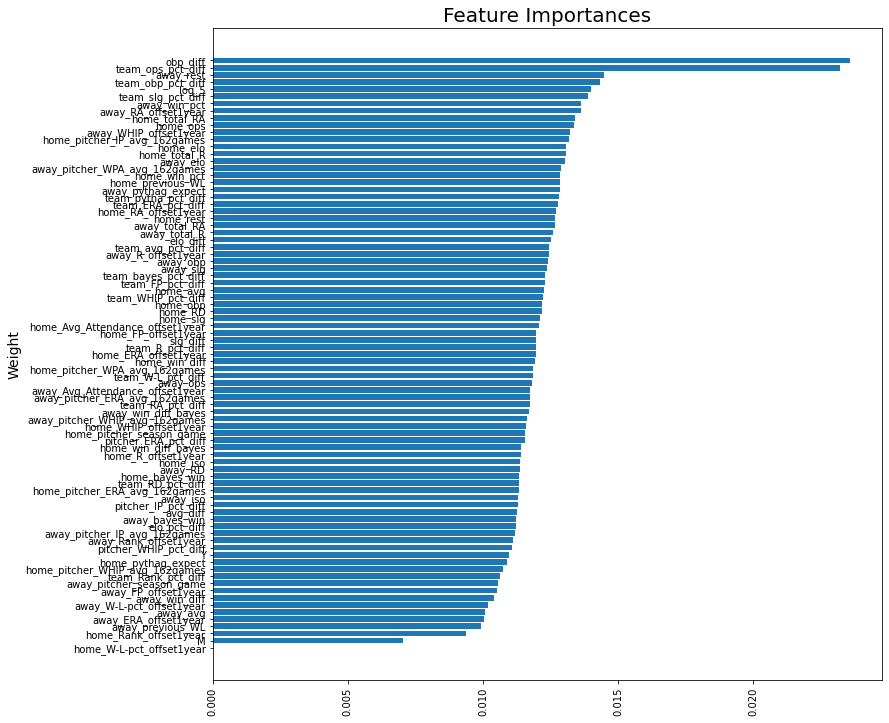

In [17]:
plt.figure(figsize=(12, 12))

x = featuredf.index
y = featuredf[0]

plt.barh(x, y)
plt.xticks(rotation=90)
plt.title('Feature Importances', fontsize=20)
plt.ylabel('Weight', fontsize=14);

### Undersample Model

In [18]:
train_df['should_drop'].value_counts()

1    24658
0    12535
Name: should_drop, dtype: int64

In [19]:
# Get only the customers who did not churn
train_1_df = train_df[train_df['should_drop'] == 1]
# Then select 3620 of them to match the 3620 "No" churn customers
train_1_df = train_1_df.sample(12535)

# Also grab the churning customers
train_0_df = train_df[train_df['should_drop'] == 0]

# And now stick both DataFrames together to make a new undersampled training set
undersample_df = pd.concat([train_0_df, train_1_df])

In [20]:
cols_to_drop = ['home_team', 'away_team', 'should_drop', 'xgb_train_pred', 'nn_train_pred', 'knn_no_batting_train_pred', 'add'] + ['xgb_pred', 'nn_pred', 'knn_pred', 'knn_no_batting_pred', 'xgb_proba', 'nn_proba', 'knn_proba','knn_no_batting_proba', 'home_team', 'away_team']
train_cols_to_drop = list(set(undersample_df.columns).intersection(set(cols_to_drop)))
test_cols_to_drop = list(set(test_df.columns).intersection(set(cols_to_drop)))

undersample_df = undersample_df.drop(train_cols_to_drop, axis=1)
test_df = test_df.drop(test_cols_to_drop, axis=1)

In [21]:
common_cols = list(set(undersample_df.columns).intersection(set(test_df.columns)))

test_df = test_df[common_cols]
undersample_df = undersample_df[common_cols]

In [22]:
X_train = undersample_df.drop('home_win', axis=1)
y_train = undersample_df.home_win.astype(int)
X_test = test_df.drop('home_win', axis=1)
y_test = test_df.home_win.astype(int)

In [23]:
params = {'n_estimators': 100,
         'max_depth': 5,
         'min_child_weight': 0.3256355793000354,
         'eta': 0.3076951770384403,
         'subsample': 0.8242904472901268,
         'colsample_bytree': 0.9475703665037462,
         'gamma': 9.66425615956974,
         'seed': 0,
         'nthread': 4,
         'objective': 'binary:logistic',
         'eval_metric': 'auc'}

In [24]:
xgb_undersample_clf = xgb.XGBClassifier(**params)

In [25]:
xgb_undersample_clf.fit(X_train, y_train)

/opt/miniconda3/lib/python3.7/site-packages/xgboost/sklearn.py:892: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9475703665037462,
              eta=0.3076951770384403, eval_metric='auc', gamma=9.66425615956974,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.30769518, max_delta_step=0, max_depth=5,
              min_child_weight=0.3256355793000354, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4, nthread=4,
              num_parallel_tree=1, random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, seed=0, subsample=0.8242904472901268,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [26]:
xgb_undersample_preds = xgb_undersample_clf.predict(X_test)

test_acc = accuracy_score(y_test, xgb_undersample_preds)
print(f'Test acc = {100*test_acc:.2f}%')

Test acc = 53.22%


In [27]:
featuredf = pd.DataFrame(xgb_undersample_clf.feature_importances_, X_train.columns)   #This makes it in order
featuredf = featuredf.sort_values(by=0, ascending=True)

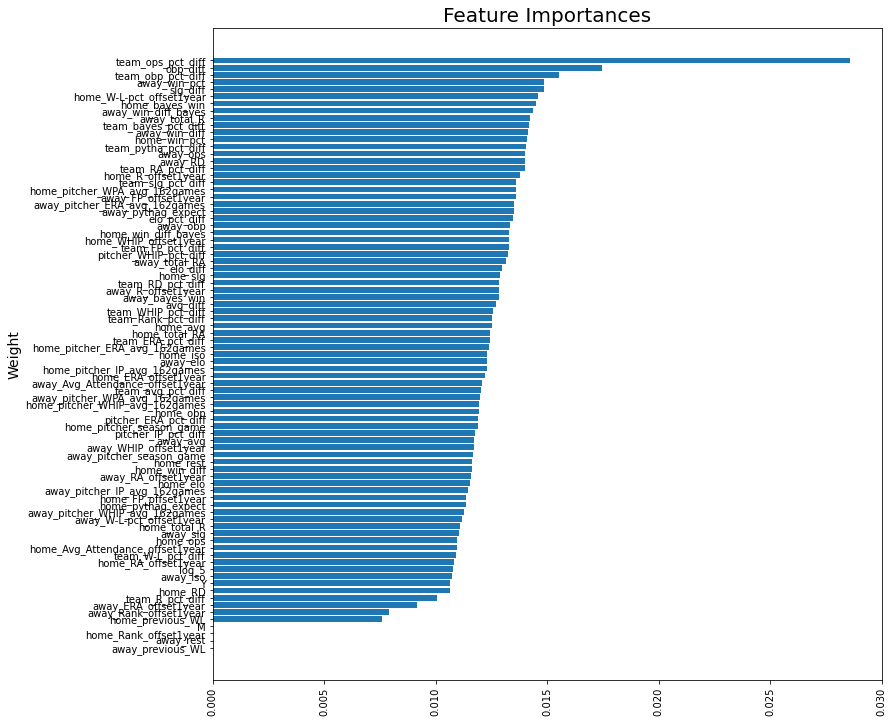

In [28]:
plt.figure(figsize=(12, 12))

x = featuredf.index
y = featuredf[0]

plt.barh(x, y)
plt.xticks(rotation=90)
plt.title('Feature Importances', fontsize=20)
plt.ylabel('Weight', fontsize=14);

### Loading Previous XGB Model 

In [29]:
df = pd.read_csv('../data/Final Data/start_to_finish_with_preds.csv')

In [30]:
df['xgb_oversample_pred'] = xgb_oversample_preds
df['xgb_undersample_pred'] = xgb_undersample_preds

## Comparing Results with eachother

In [31]:
num_correct = 0

for i in range(y_test.shape[0]):
    if y_test.values[i] in [xgb_oversample_preds[i], xgb_undersample_preds[i]]:
        num_correct += 1

print(f'Maximum possible accuracy = {100*num_correct / y_test.shape[0]:.2f}%')

Maximum possible accuracy = 73.31%


In [32]:
conditions = [(df['xgb_undersample_pred'] != df['xgb_oversample_pred'])]     #Sets the conditions
choices = [1]
df['disagree_over_under'] = np.select(conditions, choices, 0)

In [33]:
conditions = [(df['xgb_undersample_pred'] == df['xgb_oversample_pred'])]     #Sets the conditions
choices = [1]
df['agree_over_under'] = np.select(conditions, choices, 0)

In [34]:
disagree_df = df[df['disagree_over_under'] == 1]
agree_df = df[df['agree_over_under'] == 1]

In [35]:
disagree_df.shape[0]

3831

In [36]:
agree_correct_pct = agree_df[agree_df['xgb_undersample_pred'] == agree_df['home_win']].shape[0] / agree_df.shape[0]

print(f'{round(agree_correct_pct*100,2)}%')

56.57%


## Comparing Results to Main XGB

In [37]:
xgb_main_pred = df.xgb_pred

In [38]:
num_correct = 0

for i in range(y_test.shape[0]):
    if y_test.values[i] in [xgb_oversample_preds[i], xgb_main_pred[i], xgb_undersample_preds[i]]:
        num_correct += 1

print(f'Maximum possible accuracy = {100*num_correct / y_test.shape[0]:.2f}%')

Maximum possible accuracy = 85.73%


#### Main and Oversampling

In [39]:
conditions = [(df['xgb_pred'] != df['xgb_oversample_pred'])]     #Sets the conditions
choices = [1]
df['disagree_over_main'] = np.select(conditions, choices, 0)

In [40]:
conditions = [(df['xgb_pred'] == df['xgb_oversample_pred'])]     #Sets the conditions
choices = [1]
df['agree_over_main'] = np.select(conditions, choices, 0)

In [41]:
disagree_df = df[df['disagree_over_main'] == 1]
agree_df = df[df['agree_over_main'] == 1]

In [42]:
disagree_df.shape[0]

3830

In [43]:
agree_correct_pct = agree_df[agree_df['xgb_pred'] == agree_df['home_win']].shape[0] / agree_df.shape[0]

print(f'{round(agree_correct_pct*100,2)}%')

62.97%


#### Main and Undersampling

In [44]:
conditions = [(df['xgb_pred'] != df['xgb_undersample_pred'])]     #Sets the conditions
choices = [1]
df['disagree_under_main'] = np.select(conditions, choices, 0)

In [45]:
conditions = [(df['xgb_pred'] == df['xgb_undersample_pred'])]     #Sets the conditions
choices = [1]
df['agree_under_main'] = np.select(conditions, choices, 0)

In [46]:
disagree_df = df[df['disagree_under_main'] == 1]
agree_df = df[df['agree_under_main'] == 1]

In [47]:
disagree_df.shape[0]

4265

In [48]:
agree_correct_pct = agree_df[agree_df['xgb_pred'] == agree_df['home_win']].shape[0] / agree_df.shape[0]

print(f'{round(agree_correct_pct*100,2)}%')

62.52%


### Majority Vote

In [52]:
num_correct = 0

for i in range(y_test.shape[0]):
    # Just add them up. If at least two models voted 1, then choose 1. Otherwise choose 0.
    majority_vote = np.sum([xgb_main_pred[i], xgb_oversample_preds[i], xgb_undersample_preds[i]])
    if majority_vote > 1:
        majority_vote = 1
    else:
        majority_vote = 0
    if y_test.values[i] == majority_vote:
        num_correct += 1

print(f'Majority voting accuracy = {100*num_correct / y_test.shape[0]:.2f}%')

Majority voting accuracy = 57.70%
